#### Setting global variables

In [1]:
USE_GPU       = True
DETERMINISM   = True
TRAINING      = False
IMG_DIM       = 224
IMG_SIZE      = (IMG_DIM, IMG_DIM)
IMG_SHAPE     = (IMG_DIM, IMG_DIM, 3)
NUM_CLASSES   = 4
BATCH_SIZE    = 32
SEED          = 69
EPOCHS        = 30
LEARNING_RATE = 1e-4
VAL_SPLIT     = 0.2

from pathlib import Path
DATA_DIR      = f'{Path.cwd()}/dataset'
MODEL_DIR     = f'{Path.cwd()}/models'

#### Importing and configuring tensorflow

In [2]:
# Suppress irrelevant logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

if not USE_GPU:
    # Disable GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf

if DETERMINISM:
    # For deterministic results
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()

# Allow tensorflow to use all threads available
num_threads = len(os.sched_getaffinity(0))
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

if USE_GPU:
    # Allow memory growth for effcient VRAM usage
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Loading dataset from directory and split it into training and validation subsets.

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory        = DATA_DIR,
    validation_split = VAL_SPLIT,
    subset           = "training",
    seed             = SEED,
    image_size       = IMG_SIZE,
    batch_size       = BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory        = DATA_DIR,
    validation_split = VAL_SPLIT,
    subset           = "validation",
    seed             = SEED,
    image_size       = IMG_SIZE,
    batch_size       = BATCH_SIZE)

class_names = val_ds.class_names
print(class_names)

Found 9719 files belonging to 4 classes.
Using 7776 files for training.
Found 9719 files belonging to 4 classes.
Using 1943 files for validation.
['hazardous', 'organic', 'recyclable', 'residual']


#### Validation dataset is further splt into validation and testing subset (used later for model evaluation)

In [4]:
val_batches = val_ds.cardinality()
print(val_batches)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

tf.Tensor(61, shape=(), dtype=int64)


#### All datasets are optimized and only Training and Validation datasets are augmented

In [5]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomHeight(factor=0.2),
    tf.keras.layers.RandomWidth(factor=0.2)
])

AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, augment=False):

    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
        
    # ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

# Use data augmentation only on the training set.
train_ds = prepare(train_ds, augment=True)
val_ds   = prepare(val_ds, augment=True)
test_ds  = prepare(test_ds)

#### Training all the models present in models directory and storing the metrics

In [6]:
if TRAINING:
    from pydoc import importfile
    import pickle

    for file in Path(MODEL_DIR).glob("**/*.py"):
        folder = file.parent
        print(file)
        print(f'Training {folder.name}')
        
        module = importfile(str(file))

        model = module.get_model(NUM_CLASSES)

        print(model.summary(show_trainable=True))

        model.compile(
            optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
            loss      = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics   = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"))
        
        history = model.fit(
            x               = train_ds, 
            validation_data = val_ds,
            epochs          = EPOCHS)
        
        with open(f'{folder}/history_dict', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        
        model.save(f'{folder}/final_model')

#### Plot comparison graph of validation loss and accuracy between all models

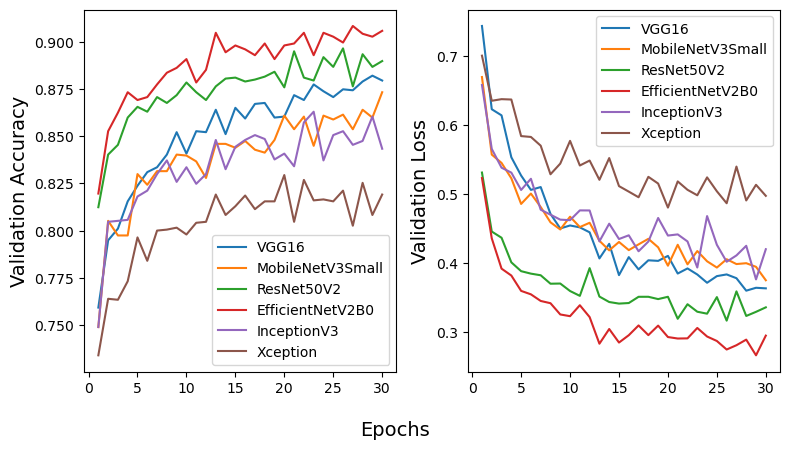

In [7]:
import matplotlib.pyplot as plt
import pickle


fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(8, 4.5))
# fig.suptitle('Horizontally stacked subplots')
fig.supxlabel('Epochs', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
ax2.set_ylabel('Validation Loss', fontsize=14)
for history in Path(MODEL_DIR).glob("**/history_dict"):
    with open(history, "rb") as file_pi:
        history_dict = pickle.load(file_pi)
    
    epoch_range = range(1, len(history_dict['val_accuracy']) + 1)
    ax1.plot(epoch_range, history_dict['val_accuracy'], label=history.parent.name)
    ax2.plot(epoch_range, history_dict['val_loss'], label=history.parent.name)

ax1.legend()
ax2.legend()
plt.show()

#### Bar plot comparing test accuracy between all models

In [8]:
models = []
acc = []

for saved_model in Path(MODEL_DIR).glob("**/final_model"):

    print(saved_model.parent.name)
    loaded_model = tf.keras.models.load_model(saved_model)
    test_loss, test_acc = loaded_model.evaluate(test_ds)

    models.append(saved_model.parent.name)
    acc.append(test_acc)

VGG16
30/30 [==============================] - 20s 568ms/step - loss: 0.3162 - accuracy: 0.8969
MobileNetV3Small
30/30 [==============================] - 4s 71ms/step - loss: 0.3124 - accuracy: 0.8958
ResNet50V2
30/30 [==============================] - 13s 381ms/step - loss: 0.2871 - accuracy: 0.9177
EfficientNetV2B0
30/30 [==============================] - 8s 193ms/step - loss: 0.1929 - accuracy: 0.9312
InceptionV3
30/30 [==============================] - 12s 310ms/step - loss: 0.3229 - accuracy: 0.8969
Xception
30/30 [==============================] - 20s 611ms/step - loss: 0.2566 - accuracy: 0.9073


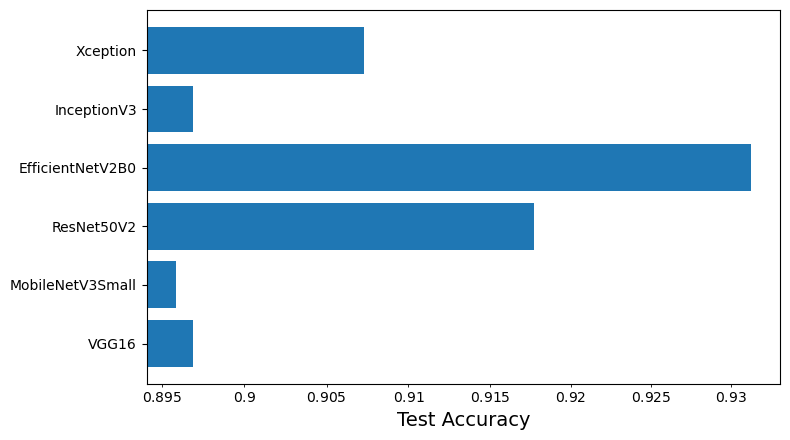

In [9]:
plt.rcParams['axes.formatter.min_exponent'] = 1
plt.figure(figsize=(8, 4.5), layout='tight')
plt.barh(models, acc)
plt.xlabel('Test Accuracy', fontsize=14)
plt.xscale('log')
plt.show()

In [ ]:
import numpy as np
from PIL import Image

image_file = '../pen.jpg'

img = np.asarray(Image.open(image_file))
plt.axis("off")
plt.imshow(img)
plt.show()

for saved_model in Path(MODEL_DIR).glob("**/final_model"):

    loaded_model = tf.keras.models.load_model(saved_model)
    img = tf.keras.preprocessing.image.load_img(image_file, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = class_names[np.argmax(loaded_model.predict(img_array, verbose=0))]
    print(f"{saved_model.parent.name}: {prediction}")

# loaded_model = tf.keras.models.load_model(f'{MODEL_DIR}/{best_model}/final_model')
# img = tf.keras.preprocessing.image.load_img(image_file, target_size=IMG_SIZE)
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)

# prediction = class_names[np.argmax(loaded_model.predict(img_array, verbose=0))]

# img = np.asarray(Image.open(image_file))
# plt.axis("off")
# plt.title(f'{prediction}', fontsize=28)
# plt.imshow(img)